### import data

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, MaxNLocator
from matplotlib.dates import MonthLocator

%matplotlib inline

In [2]:
%store -r sc_customers
%store -r sc_products
%store -r sc_categories_departments
%store -r sc_orders
%store -r sc_orders_ratio
%store -r sc_orders_demographic
%store -r sc_shipping

In [3]:
pd.set_option('display.max_rows', 20)

In [4]:
all_column_name = (
    sc_customers.columns.tolist() +
    sc_products.columns.tolist() +
    sc_categories_departments.columns.tolist() +
    sc_orders.columns.tolist() +
    sc_orders_demographic.columns.tolist() +
    sc_shipping.columns.tolist()
    )
all_column_name

['customer_id',
 'first_name',
 'last_name',
 'segment',
 'country',
 'state',
 'city',
 'street',
 'zipcode',
 'product_id',
 'product_name',
 'category_id',
 'department_id',
 'price',
 'product_image',
 'category_id',
 'category',
 'department_id',
 'department',
 'order_id',
 'transaction_id',
 'customer_id',
 'order_date',
 'payment_type',
 'product_id',
 'price',
 'quantity',
 'gross_sale',
 'discount_pct',
 'discount',
 'net_sale',
 'order_id',
 'transaction_id',
 'order_date',
 'type',
 'customer_id',
 'latitiude',
 'longitude',
 'market',
 'region',
 'country',
 'state',
 'city',
 'zipcode',
 'order_status',
 'order_id',
 'transaction_id',
 'order_date',
 'customer_id',
 'product_id',
 'shipping_date',
 'mode',
 'days_shipping_scheduled',
 'days_shipping_real',
 'delivery_status',
 'risk']

# Request 1
## Analyze the relationship between the 'days_shipping_real' and the 'risk.'

## Investigate whether orders with longer shipping durations are more likely to be at risk of late delivery.

## Additionally, break down the analysis by different product categories to see if the relationship varies across product types.

## Provide insights into potential factors contributing to late deliveries based on the shipping duration and product categories.

In [5]:
sc_shipping

,order_id,transaction_id,order_date,customer_id,product_id,shipping_date,mode,days_shipping_scheduled,days_shipping_real,delivery_status,risk
0,44371,110769,2016-10-09 16:47:00,7537,627,2016-10-10 04:47:00,Same Day,0,1,Late delivery,True
1,18065,45146,2015-09-21 16:37:00,1521,1014,2015-09-27 16:37:00,Standard Class,4,6,Late delivery,True
2,33158,82891,2016-04-29 00:22:00,5849,502,2016-05-01 00:22:00,First Class,1,2,Late delivery,True
3,73677,176992,2017-12-11 11:59:00,4848,1362,2017-12-14 11:59:00,Standard Class,4,3,Advance shipping,False
4,5834,14520,2015-03-27 03:33:00,4515,1004,2015-04-01 03:33:00,Standard Class,4,5,Late delivery,True
...,...,...,...,...,...,...,...,...,...,...,...
180514,8364,20897,2015-05-03 01:55:00,4038,1004,2015-05-08 01:55:00,Second Class,2,5,Late delivery,True
180515,14594,36501,2015-08-02 00:34:00,698,502,2015-08-07 00:34:00,Standard Class,4,5,Late delivery,True
180516,38897,97110,2016-07-21 19:00:00,290,403,2016-07-24 19:00:00,Second Class,2,3,Late delivery,True
180517,66417,166028,2017-08-27 12:28:00,11978,957,2017-08-30 12:28:00,Standard Class,4,3,Advance shipping,False


In [6]:
sc_shipping[(sc_shipping['delivery_status'] == 'Late delivery') & (sc_shipping['days_shipping_real'] == 3)].count()

order_id                   6759
transaction_id             6759
order_date                 6759
customer_id                6759
product_id                 6759
shipping_date              6759
mode                       6759
days_shipping_scheduled    6759
days_shipping_real         6759
delivery_status            6759
risk                       6759
dtype: int64

### what does risk mean? risk is defined by whether or not a delivery was late. 1= late and 0 = not late

In [7]:
sc_shipping['risk'].value_counts()[1]

81542

In [8]:
sc_shipping['delivery_status'].value_counts()['Late delivery']

98977

In [9]:
sc_shipping[(sc_shipping['delivery_status'] == 'Late delivery') & (sc_shipping['risk'] == 1)]['risk'].value_counts()

True    98977
Name: risk, dtype: int64

### A correlation coefficient of 0.401415 indicates a positive correlation between two variables, but the strength of the correlation is moderate.

In [10]:
sc_shipping[['days_shipping_real', 'risk']].corr()

,days_shipping_real,risk
days_shipping_real,1.000000,0.401415
risk,0.401415,1.000000


### aggregate shipments by delivery status, display in a barplot

In [11]:
sc_shipping['delivery_status'].drop_duplicates()

0         Late delivery
3      Advance shipping
11     Shipping on time
15    Shipping canceled
Name: delivery_status, dtype: object

In [12]:
shipping_pivot = sc_shipping.pivot_table(index='days_shipping_real', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot= shipping_pivot[['days_shipping_real', 'Advance shipping', 'Shipping canceled', 'Late delivery', 'Shipping on time']]
shipping_pivot

delivery_status,days_shipping_real,Advance shipping,Shipping canceled,Late delivery,Shipping on time
0,0,0,241,0,4839
1,1,0,203,4454,0
2,2,20873,2413,26513,6819
3,3,20719,1287,6759,0
4,4,0,1216,6759,20538
5,5,0,1160,27003,0
6,6,0,1234,27489,0


In [13]:
shipping_pivot.columns = ['days_shipping_real', 'n_advanced', 'n_cancelled', 'n_late', 'n_on_time']
shipping_pivot = shipping_pivot[['days_shipping_real', 'n_advanced', 'n_on_time', 'n_late', 'n_cancelled']]
shipping_pivot

,days_shipping_real,n_advanced,n_on_time,n_late,n_cancelled
0,0,0,4839,0,241
1,1,0,0,4454,203
2,2,20873,6819,26513,2413
3,3,20719,0,6759,1287
4,4,0,20538,6759,1216
5,5,0,0,27003,1160
6,6,0,0,27489,1234


total = sc_shipping.groupby('days_shipping_real')['delivery_status'].count().reset_index(name='total')
total

shipping_merge = shipping_pivot.merge(total, on='days_shipping_real')

shipping_merge = shipping_merge[['days_shipping_real', 'total', 'n_advanced', 'n_on_time', 'n_late', 'n_cancelled']]
shipping_merge

In [14]:
stains = [
 'blue : #578C1D',
 'green : #22A3CF',
 'red : #FF614E']

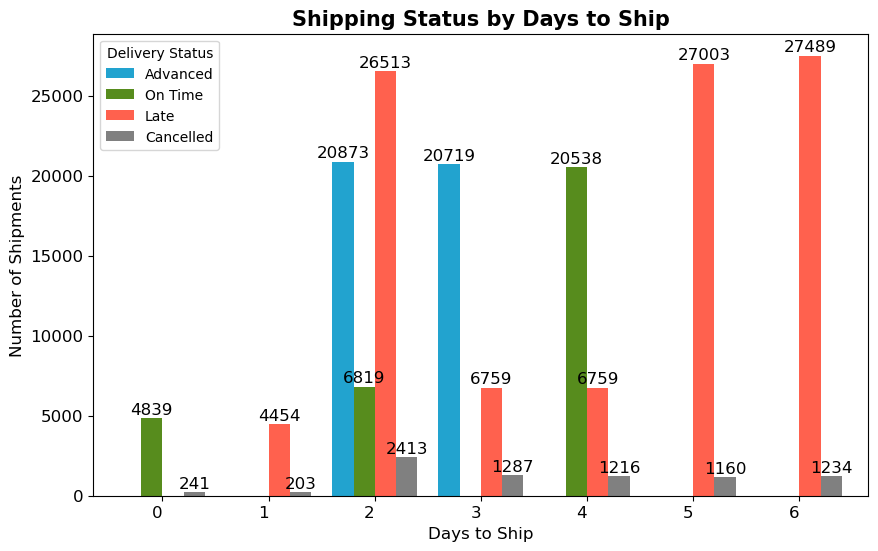

In [15]:
ax = shipping_pivot.plot(kind='bar', x='days_shipping_real', stacked=False, figsize=(10, 6), width=0.8, color=['#22A3CF', '#578C1D', '#FF614E', 'grey'])

plt.title('Shipping Status by Days to Ship', fontsize=15, fontweight='bold')
plt.xlabel('Days to Ship', fontsize=12)
plt.ylabel('Number of Shipments', fontsize=12)
plt.legend(title='Delivery Status', labels=['Advanced', 'On Time', 'Late', 'Cancelled'], title_fontsize=10, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=12)

In [16]:
total = sc_shipping.groupby('days_shipping_real')['delivery_status'].count().reset_index(name='total')
total

,days_shipping_real,total
0,0,5080
1,1,4657
2,2,56618
3,3,28765
4,4,28513
5,5,28163
6,6,28723


In [17]:
shipping_merge = shipping_pivot.merge(total, on='days_shipping_real')
shipping_merge = shipping_merge[['days_shipping_real', 'total', 'n_advanced', 'n_on_time', 'n_late', 'n_cancelled']]
shipping_merge

,days_shipping_real,total,n_advanced,n_on_time,n_late,n_cancelled
0,0,5080,0,4839,0,241
1,1,4657,0,0,4454,203
2,2,56618,20873,6819,26513,2413
3,3,28765,20719,0,6759,1287
4,4,28513,0,20538,6759,1216
5,5,28163,0,0,27003,1160
6,6,28723,0,0,27489,1234


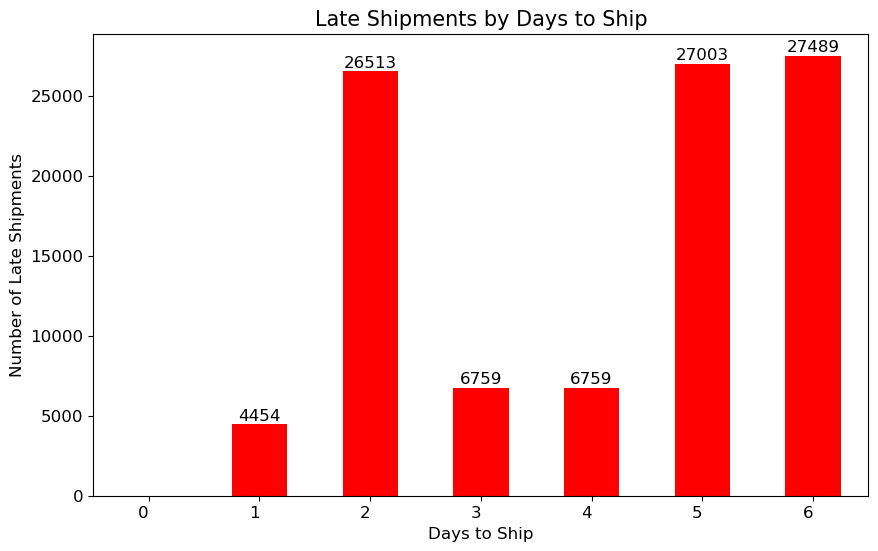

In [18]:
ax = shipping_merge['n_late'].plot(kind='bar', x='days_shipping_real', stacked=False, figsize=(10, 6), color='red')

plt.title('Late Shipments by Days to Ship', fontsize=15)
plt.xlabel('Days to Ship', fontsize=12)
plt.ylabel('Number of Late Shipments', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=12)

### aggregate shipments by delivery status, display in a pie plot

In [19]:
shipping_merge

,days_shipping_real,total,n_advanced,n_on_time,n_late,n_cancelled
0,0,5080,0,4839,0,241
1,1,4657,0,0,4454,203
2,2,56618,20873,6819,26513,2413
3,3,28765,20719,0,6759,1287
4,4,28513,0,20538,6759,1216
5,5,28163,0,0,27003,1160
6,6,28723,0,0,27489,1234


In [20]:
shipping_melt = pd.melt(shipping_merge, id_vars=['days_shipping_real'], var_name='delivery_status', value_name='value')
shipping_melt

,days_shipping_real,delivery_status,value
0,0,total,5080
1,1,total,4657
2,2,total,56618
3,3,total,28765
4,4,total,28513
...,...,...,...
30,2,n_cancelled,2413
31,3,n_cancelled,1287
32,4,n_cancelled,1216
33,5,n_cancelled,1160


In [21]:
shipping_pie = shipping_melt.pivot(index='delivery_status', columns='days_shipping_real', values='value').reset_index().rename_axis(columns=None)
shipping_pie

,delivery_status,0,1,2,3,4,5,6
0,n_advanced,0,0,20873,20719,0,0,0
1,n_cancelled,241,203,2413,1287,1216,1160,1234
2,n_late,0,4454,26513,6759,6759,27003,27489
3,n_on_time,4839,0,6819,0,20538,0,0
4,total,5080,4657,56618,28765,28513,28163,28723


In [22]:
shipping_pie = shipping_pie.rename(columns={0:'0_days_to_ship', 1:'1_days_to_ship', 2:'2_days_to_ship', 3:'3_days_to_ship', 4:'4_days_to_ship', 5:'5_days_to_ship', 6:'6_days_to_ship'})
shipping_pie

,delivery_status,0_days_to_ship,1_days_to_ship,2_days_to_ship,3_days_to_ship,4_days_to_ship,5_days_to_ship,6_days_to_ship
0,n_advanced,0,0,20873,20719,0,0,0
1,n_cancelled,241,203,2413,1287,1216,1160,1234
2,n_late,0,4454,26513,6759,6759,27003,27489
3,n_on_time,4839,0,6819,0,20538,0,0
4,total,5080,4657,56618,28765,28513,28163,28723


In [23]:
stains = ['blue : #578C1D', 'green : #22A3CF', 'red : #FF614E, yellow : #DBE363']
stains

['blue : #578C1D', 'green : #22A3CF', 'red : #FF614E, yellow : #DBE363']

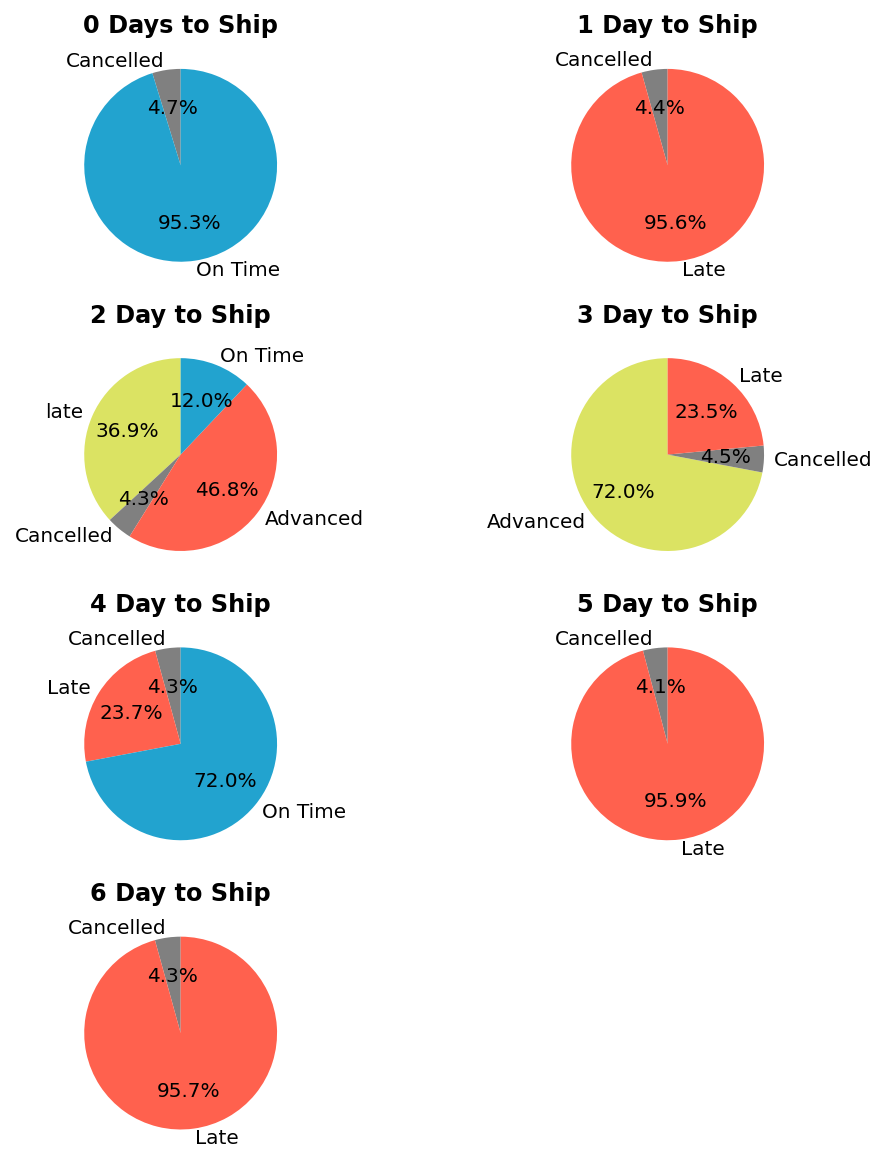

In [24]:
fig = plt.figure(figsize=(8, 10),dpi=144)

ax1 = fig.add_subplot(4, 2, 1)
ax1.pie(shipping_pie['0_days_to_ship'].drop(index=[4, 2, 0]), autopct='%1.1f%%', startangle=90, colors=['grey', '#22A3CF'], labels=['Cancelled', 'On Time'])
ax1.set_title('0 Days to Ship', fontsize=12, fontweight='bold')

ax2 = fig.add_subplot(4, 2, 2)
ax2.pie(shipping_pie['1_days_to_ship'].drop(index=[4, 0, 3]), autopct='%1.1f%%', startangle=90, colors=['grey', '#FF614E'], labels=['Cancelled', 'Late'])
ax2.set_title('1 Day to Ship', fontsize=12, fontweight='bold')

ax3 = fig.add_subplot(4, 2, 3)
ax3.pie(shipping_pie['2_days_to_ship'].drop(index=[4]), autopct='%1.1f%%', startangle=90, colors=['#DBE363', 'grey', '#FF614E', '#22A3CF'], labels=['late', 'Cancelled', 'Advanced', 'On Time'])
ax3.set_title('2 Day to Ship', fontsize=12, fontweight='bold')

ax4 = fig.add_subplot(4, 2, 4)
ax4.pie(shipping_pie['3_days_to_ship'].drop(index=[4, 3]), autopct='%1.1f%%', startangle=90, colors=['#DBE363', 'grey', '#FF614E'], labels=['Advanced', 'Cancelled', 'Late',])
ax4.set_title('3 Day to Ship', fontsize=12, fontweight='bold')

ax5 = fig.add_subplot(4, 2, 5)
ax5.pie(shipping_pie['4_days_to_ship'].drop(index=[4, 0]), autopct='%1.1f%%', startangle=90, colors=['grey', '#FF614E', '#22A3CF'], labels=['Cancelled', 'Late', 'On Time'])
ax5.set_title('4 Day to Ship', fontsize=12, fontweight='bold')

ax6 = fig.add_subplot(4, 2, 6)
ax6.pie(shipping_pie['5_days_to_ship'].drop(index=[4, 0, 3]), autopct='%1.1f%%', startangle=90, colors=['grey', '#FF614E'], labels=['Cancelled', 'Late'])
ax6.set_title('5 Day to Ship', fontsize=12, fontweight='bold')

ax7 = fig.add_subplot(4, 2, 7)
ax7.pie(shipping_pie['6_days_to_ship'].drop(index=[4, 0, 3]), autopct='%1.1f%%', startangle=90, colors=['grey', '#FF614E'], labels=['Cancelled', 'Late'])
ax7.set_title('6 Day to Ship', fontsize=12, fontweight='bold')

plt.show()

### incorporate product catagories into analysis

In [25]:
shipping_merge = sc_shipping.merge(sc_products, on='product_id').merge(sc_categories_departments, on='category_id')
shipping_merge = shipping_merge[['order_id', 'transaction_id', 'order_date', 'days_shipping_real', 'delivery_status', 'risk', 'product_id', 'product_name', 'category', 'department']]
shipping_merge

,order_id,transaction_id,order_date,days_shipping_real,delivery_status,risk,product_id,product_name,category,department
0,44371,110769,2016-10-09 16:47:00,1,Late delivery,True,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
1,14096,35269,2015-07-25 18:06:00,2,Advance shipping,False,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
2,57645,144199,2017-04-21 11:15:00,6,Late delivery,True,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
3,3440,8551,2015-02-20 04:50:00,0,Shipping on time,False,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
4,35310,88185,2016-05-30 10:18:00,6,Late delivery,True,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
...,...,...,...,...,...,...,...,...,...,...
180514,62772,156939,2017-07-05 07:28:00,2,Late delivery,True,359,Nike Men's Free TR 5.0 TB Training Shoe,As Seen on TV!,Footwear
180515,62546,156317,2017-07-02 00:17:00,2,Shipping canceled,False,359,Nike Men's Free TR 5.0 TB Training Shoe,As Seen on TV!,Footwear
180516,59667,149324,2017-05-20 23:39:00,3,Advance shipping,False,359,Nike Men's Free TR 5.0 TB Training Shoe,As Seen on TV!,Footwear
180517,66574,166404,2017-08-29 19:29:00,5,Late delivery,True,359,Nike Men's Free TR 5.0 TB Training Shoe,As Seen on TV!,Footwear


In [26]:
shipping_group = shipping_merge.groupby('category')
correlation_results = shipping_group[['days_shipping_real', 'risk']].corr().unstack()['days_shipping_real']['risk']
print('pct_late mean:', correlation_results.mean())
print('pct_late std:', correlation_results.std())
print('pct_late one std:', correlation_results.std() + correlation_results.mean())
correlation_results.sort_values(ascending=False)

pct_late mean: 0.4009439075766828
pct_late std: 0.05485351702775462
pct_late one std: 0.4557974246044374


category
Men's Golf Clubs     0.525869
Soccer               0.514905
Computers            0.487100
Basketball           0.485297
As Seen on  TV!      0.481512
                       ...   
Books                0.317646
Pet Supplies         0.310695
Baby                 0.298282
Golf Bags & Carts    0.264284
Cameras              0.262387
Name: risk, Length: 50, dtype: float64

In [27]:
shipping_merge['category'].value_counts()

Cleats                  24551
Men's Footwear          22246
Women's Apparel         21035
Indoor/Outdoor Games    19298
Fishing                 17325
                        ...  
Soccer                    138
Strength Training         111
As Seen on  TV!            68
Basketball                 67
Golf Bags & Carts          61
Name: category, Length: 50, dtype: int64

### aggregate shipments by delivery status, days to ship and product category, display in a heatmap

In [28]:
shipping_pivot_all = shipping_merge.pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_all.columns = ['category', 'n_advanced', 'n_late', 'n_cancelled', 'n_on_time']
shipping_pivot_all['total'] = shipping_pivot_all['n_advanced'] + shipping_pivot_all['n_on_time'] + shipping_pivot_all['n_cancelled'] + shipping_pivot_all['n_late']
shipping_pivot_all['n_not_late'] = shipping_pivot_all['n_advanced'] + shipping_pivot_all['n_on_time'] + shipping_pivot_all['n_cancelled']
shipping_pivot_all['pct_late'] = round((shipping_pivot_all['n_late'] / shipping_pivot_all['total']) * 100, 2)
shipping_pivot_all

,category,n_advanced,n_late,n_cancelled,n_on_time,total,n_not_late,pct_late
0,Accessories,406,1014,83,277,1780,766,56.97
1,As Seen on TV!,15,39,2,12,68,29,57.35
2,Baby,49,109,9,40,207,98,52.66
3,Baseball & Softball,141,349,25,117,632,283,55.22
4,Basketball,22,37,3,5,67,30,55.22
...,...,...,...,...,...,...,...,...
45,Video Games,190,455,34,159,838,383,54.30
46,Water Sports,3547,8517,660,2816,15540,7023,54.81
47,Women's Apparel,4886,11476,919,3754,21035,9559,54.56
48,Women's Clothing,145,367,19,119,650,283,56.46


In [29]:
shipping_pivot_all.columns.tolist()

['category',
 'n_advanced',
 'n_late',
 'n_cancelled',
 'n_on_time',
 'total',
 'n_not_late',
 'pct_late']

In [30]:
shipping_pie

,delivery_status,0_days_to_ship,1_days_to_ship,2_days_to_ship,3_days_to_ship,4_days_to_ship,5_days_to_ship,6_days_to_ship
0,n_advanced,0,0,20873,20719,0,0,0
1,n_cancelled,241,203,2413,1287,1216,1160,1234
2,n_late,0,4454,26513,6759,6759,27003,27489
3,n_on_time,4839,0,6819,0,20538,0,0
4,total,5080,4657,56618,28765,28513,28163,28723


In [31]:
shipping_pivot_0 = shipping_merge[shipping_merge['days_shipping_real'] == 0].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_0.columns = ['category', 'n_cancelled', 'n_on_time']
shipping_pivot_0['n_advanced'] = 0
shipping_pivot_0['n_late'] = 0
shipping_pivot_0['total'] = shipping_pivot_0['n_advanced'] + shipping_pivot_0['n_on_time'] + shipping_pivot_0['n_cancelled'] + shipping_pivot_0['n_late']
shipping_pivot_0['n_not_late'] = shipping_pivot_0['n_advanced'] + shipping_pivot_0['n_on_time'] + shipping_pivot_0['n_cancelled']
shipping_pivot_0['pct_late'] = round((shipping_pivot_0['n_late'] / shipping_pivot_0['total']) * 100, 2)

In [32]:
shipping_pivot_1 = shipping_merge[shipping_merge['days_shipping_real'] == 1].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_1.columns = ['category', 'n_late', 'n_cancelled']
shipping_pivot_1['n_advanced'] = 0
shipping_pivot_1['n_on_time'] = 0
shipping_pivot_1['total'] = shipping_pivot_1['n_advanced'] + shipping_pivot_1['n_on_time'] + shipping_pivot_1['n_cancelled'] + shipping_pivot_1['n_late']
shipping_pivot_1['n_not_late'] = shipping_pivot_1['n_advanced'] + shipping_pivot_1['n_on_time'] + shipping_pivot_1['n_cancelled']
shipping_pivot_1['pct_late'] = round((shipping_pivot_1['n_late'] / shipping_pivot_1['total']) * 100, 2)

In [33]:
shipping_pivot_2 = shipping_merge[shipping_merge['days_shipping_real'] == 2].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_2.columns = ['category', 'n_advanced', 'n_late', 'n_cancelled', 'n_on_time']
shipping_pivot_2['total'] = shipping_pivot_2['n_advanced'] + shipping_pivot_2['n_on_time'] + shipping_pivot_2['n_cancelled'] + shipping_pivot_2['n_late']
shipping_pivot_2['n_not_late'] = shipping_pivot_2['n_advanced'] + shipping_pivot_2['n_on_time'] + shipping_pivot_2['n_cancelled']
shipping_pivot_2['pct_late'] = round((shipping_pivot_2['n_late'] / shipping_pivot_2['total']) * 100, 2)

In [34]:
shipping_pivot_3 = shipping_merge[shipping_merge['days_shipping_real'] == 3].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_3.columns = ['category', 'n_advanced', 'n_late', 'n_cancelled']
shipping_pivot_3['n_on_time'] = 0
shipping_pivot_3['total'] = shipping_pivot_3['n_advanced'] + shipping_pivot_3['n_on_time'] + shipping_pivot_3['n_cancelled'] + shipping_pivot_3['n_late']
shipping_pivot_3['n_not_late'] = shipping_pivot_3['n_advanced'] + shipping_pivot_3['n_on_time'] + shipping_pivot_3['n_cancelled']
shipping_pivot_3['pct_late'] = round((shipping_pivot_3['n_late'] / shipping_pivot_3['total']) * 100, 2)

In [35]:
shipping_pivot_4 = shipping_merge[shipping_merge['days_shipping_real'] == 4].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_4.columns = ['category', 'n_late', 'n_cancelled', 'n_on_time']
shipping_pivot_4['n_advanced'] = 0
shipping_pivot_4['total'] = shipping_pivot_4['n_advanced'] + shipping_pivot_4['n_on_time'] + shipping_pivot_4['n_cancelled'] + shipping_pivot_4['n_late']
shipping_pivot_4['n_not_late'] = shipping_pivot_4['n_advanced'] + shipping_pivot_4['n_on_time'] + shipping_pivot_4['n_cancelled']
shipping_pivot_4['pct_late'] = round((shipping_pivot_4['n_late'] / shipping_pivot_4['total']) * 100, 2)

In [36]:
shipping_pivot_5 = shipping_merge[shipping_merge['days_shipping_real'] == 5].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_5.columns = ['category', 'n_late', 'n_cancelled']
shipping_pivot_5['n_advanced'] = 0
shipping_pivot_5['n_on_time'] = 0
shipping_pivot_5['total'] = shipping_pivot_5['n_advanced'] + shipping_pivot_5['n_on_time'] + shipping_pivot_5['n_cancelled'] + shipping_pivot_5['n_late']
shipping_pivot_5['n_not_late'] = shipping_pivot_5['n_advanced'] + shipping_pivot_5['n_on_time'] + shipping_pivot_5['n_cancelled']
shipping_pivot_5['pct_late'] = round((shipping_pivot_5['n_late'] / shipping_pivot_5['total']) * 100, 2)

In [37]:
shipping_pivot_6 = shipping_merge[shipping_merge['days_shipping_real'] == 5].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_6.columns = ['category', 'n_late', 'n_cancelled']
shipping_pivot_6['n_advanced'] = 0
shipping_pivot_6['n_on_time'] = 0
shipping_pivot_6['total'] = shipping_pivot_6['n_advanced'] + shipping_pivot_6['n_on_time'] + shipping_pivot_6['n_cancelled'] + shipping_pivot_6['n_late']
shipping_pivot_6['n_not_late'] = shipping_pivot_6['n_advanced'] + shipping_pivot_6['n_on_time'] + shipping_pivot_6['n_cancelled']
shipping_pivot_6['pct_late'] = round((shipping_pivot_6['n_late'] / shipping_pivot_6['total']) * 100, 2)

In [38]:
shipping_pivot_pct = shipping_pivot_2[['category', 'pct_late']].merge(shipping_pivot_0[['category', 'pct_late']], how='left', on='category').merge(shipping_pivot_1[['category', 'pct_late']], on='category')
shipping_pivot_pct.columns = ['category', '2', '0', '1']
shipping_pivot_pct = shipping_pivot_pct.merge(shipping_pivot_3[['category', 'pct_late']], on='category').merge(shipping_pivot_4[['category', 'pct_late']], on='category').merge(shipping_pivot_5[['category', 'pct_late']], on='category')
shipping_pivot_pct.columns = ['category', '2', '0', '1', '3', '4', '5']
shipping_pivot_pct = shipping_pivot_pct.merge(shipping_pivot_6[['category', 'pct_late']], on='category')
shipping_pivot_pct.columns = ['category', '2', '0', '1', '3', '4', '5', '6']
shipping_pivot_pct = shipping_pivot_pct[['category', '0', '1', '2', '3', '4', '5', '6']].fillna(0)
shipping_pivot_pct.set_index('category', inplace=True)
shipping_pivot_pct

,0,1,2,3,4,5,6
category,,,,,,,
Accessories,0.0,95.35,48.86,26.69,27.86,96.07,96.07
As Seen on TV!,0.0,100.00,42.86,40.00,18.18,100.00,100.00
Baby,0.0,100.00,50.77,15.15,20.69,92.31,92.31
Baseball & Softball,0.0,93.75,49.52,22.45,24.77,97.73,97.73
Books,0.0,96.97,46.09,20.00,19.05,96.67,96.67
...,...,...,...,...,...,...,...
Video Games,0.0,95.83,38.72,26.32,22.86,97.89,97.89
Water Sports,0.0,95.93,47.21,24.65,24.05,95.73,95.73
Women's Apparel,0.0,96.42,47.64,22.06,22.71,95.59,95.59


Text(95.7222222222222, 0.5, 'Product Category')

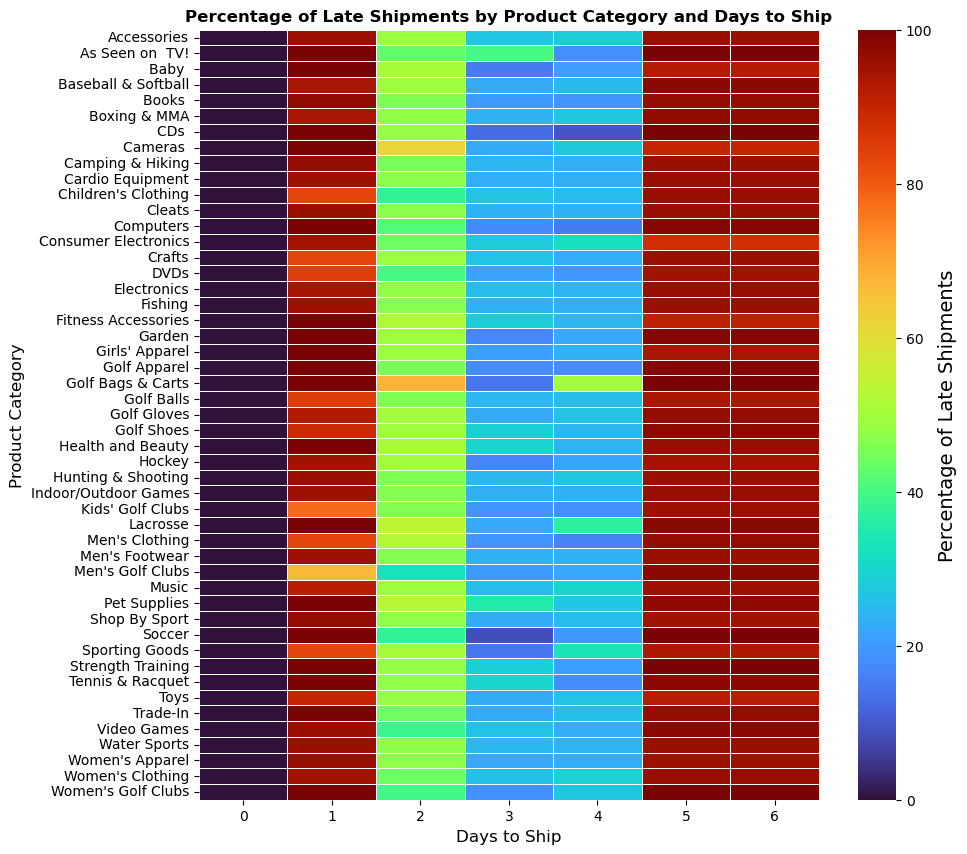

In [75]:
plt.figure(figsize=(10, 10))

ax = sns.heatmap(shipping_pivot_pct, annot=False, cmap="turbo", linewidths=.5, cbar_kws={'label': 'Percentage of Late Shipments'})

ax.collections[0].colorbar.set_label('Percentage of Late Shipments', fontsize=14)
ax.set_title('Percentage of Late Shipments by Product Category and Days to Ship', fontweight='bold', fontsize=12)
ax.set_xlabel('Days to Ship', fontsize=12)
ax.set_ylabel('Product Category', fontsize=12)

# Request 2
## Conduct a comprehensive time-series analysis of the sales data over the entire dataset duration.
## Identify any seasonality patterns, trends, or anomalies in the sales performance. 
## Furthermore, assess the impact of different marketing campaigns or promotions by correlating the dates of special promotions with spikes or dips in sales. 
## Provide actionable insights for optimizing future marketing strategies based on the historical sales patterns."

In [40]:
sc_orders

,order_id,transaction_id,customer_id,order_date,payment_type,product_id,price,quantity,gross_sale,discount_pct,discount,net_sale
0,5853,14565,9485,2015-03-27 10:12:00,PAYMENT,1004,399.980011,1,399.980011,0.10,40.000000,359.980011
1,65537,163801,968,2017-08-14 16:10:00,DEBIT,1073,199.990005,1,199.990005,0.15,30.000000,169.990005
2,22961,57465,3860,2015-12-02 03:54:00,PAYMENT,403,129.990005,1,129.990005,0.10,13.000000,116.989998
3,14430,36094,11937,2015-07-30 15:07:00,PAYMENT,191,99.989998,1,99.989998,0.15,15.000000,84.989998
4,49042,122621,10713,2016-12-16 21:14:00,TRANSFER,365,59.990002,2,119.980003,0.25,30.000000,89.980003
...,...,...,...,...,...,...,...,...,...,...,...,...
180514,65752,164333,5049,2017-08-17 19:30:00,DEBIT,1004,399.980011,1,399.980011,0.07,28.000000,371.980011
180515,1044,2603,2444,2015-01-16 05:24:00,PAYMENT,1014,49.980000,5,249.899994,0.13,32.490002,217.410004
180516,4049,10066,7956,2015-03-01 02:11:00,PAYMENT,1014,49.980000,1,49.980000,0.00,0.000000,49.980000
180517,8546,21325,12192,2015-05-05 17:41:00,PAYMENT,403,129.990005,1,129.990005,0.12,15.600000,114.389999


In [43]:
sc_orders['order_date_only'] = sc_orders['order_date'].dt.date
sc_orders['order_year_month_only'] = sc_orders['order_date'].dt.strftime('%y-%m')
sc_orders['order_day_only'] = sc_orders['order_date'].dt.day

In [44]:
sc_orders

,order_id,transaction_id,customer_id,order_date,payment_type,product_id,price,quantity,gross_sale,discount_pct,discount,net_sale,order_date_only,order_year_month_only,order_day_only
0,5853,14565,9485,2015-03-27 10:12:00,PAYMENT,1004,399.980011,1,399.980011,0.10,40.000000,359.980011,2015-03-27,15-03,27
1,65537,163801,968,2017-08-14 16:10:00,DEBIT,1073,199.990005,1,199.990005,0.15,30.000000,169.990005,2017-08-14,17-08,14
2,22961,57465,3860,2015-12-02 03:54:00,PAYMENT,403,129.990005,1,129.990005,0.10,13.000000,116.989998,2015-12-02,15-12,2
3,14430,36094,11937,2015-07-30 15:07:00,PAYMENT,191,99.989998,1,99.989998,0.15,15.000000,84.989998,2015-07-30,15-07,30
4,49042,122621,10713,2016-12-16 21:14:00,TRANSFER,365,59.990002,2,119.980003,0.25,30.000000,89.980003,2016-12-16,16-12,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,65752,164333,5049,2017-08-17 19:30:00,DEBIT,1004,399.980011,1,399.980011,0.07,28.000000,371.980011,2017-08-17,17-08,17
180515,1044,2603,2444,2015-01-16 05:24:00,PAYMENT,1014,49.980000,5,249.899994,0.13,32.490002,217.410004,2015-01-16,15-01,16
180516,4049,10066,7956,2015-03-01 02:11:00,PAYMENT,1014,49.980000,1,49.980000,0.00,0.000000,49.980000,2015-03-01,15-03,1
180517,8546,21325,12192,2015-05-05 17:41:00,PAYMENT,403,129.990005,1,129.990005,0.12,15.600000,114.389999,2015-05-05,15-05,5


In [45]:
sc_orders.groupby('order_date_only')['net_sale'].sum().reset_index()

,order_date_only,net_sale
0,2015-01-01,29379.689453
1,2015-01-02,26801.849609
2,2015-01-03,32859.261719
3,2015-01-04,31869.460938
4,2015-01-05,27532.990234
...,...,...
1122,2018-01-27,13253.509766
1123,2018-01-28,13372.219727
1124,2018-01-29,13130.490234
1125,2018-01-30,13362.500000


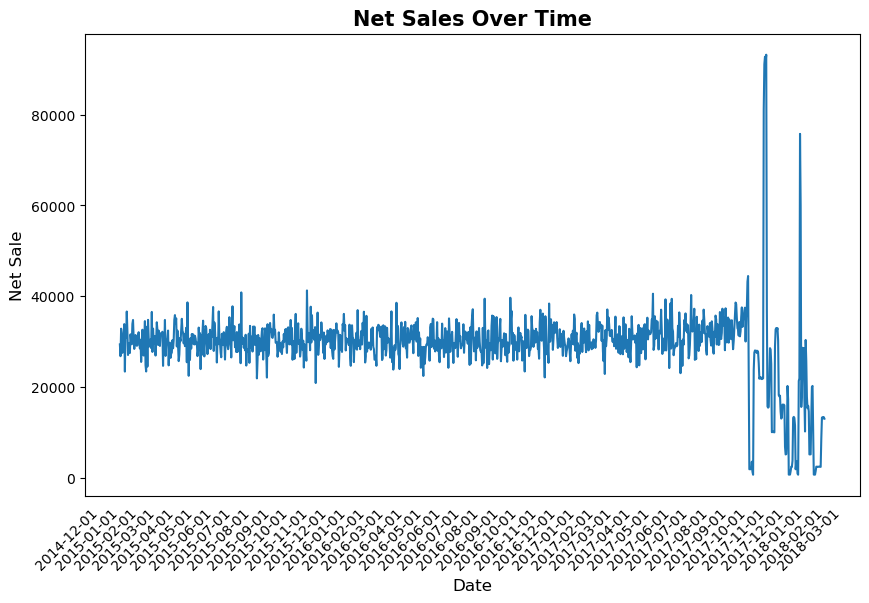

In [87]:
plt.figure(figsize=(10, 6))

plot_data = sc_orders.groupby('order_date_only')['net_sale'].sum().reset_index()
ax = sns.lineplot(data=plot_data, x='order_date_only', y='net_sale')

ax.set_title('Net Sales Over Time', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net Sale', fontsize=12)
ax.xaxis.set_major_locator(MonthLocator())
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([item.get_text() for item in ax.get_xticklabels()], rotation=45, horizontalalignment='right')
ax.tick_params(bottom=False)

plt.show()

In [47]:
sc_orders[sc_orders['order_year_month_only'] > '17-08'].groupby('order_date_only')['net_sale'].sum().reset_index()

,order_date_only,net_sale
0,2017-09-01,34892.449219
1,2017-09-02,31115.531250
2,2017-09-03,33474.359375
3,2017-09-04,30548.609375
4,2017-09-05,34723.039062
...,...,...
148,2018-01-27,13253.509766
149,2018-01-28,13372.219727
150,2018-01-29,13130.490234
151,2018-01-30,13362.500000


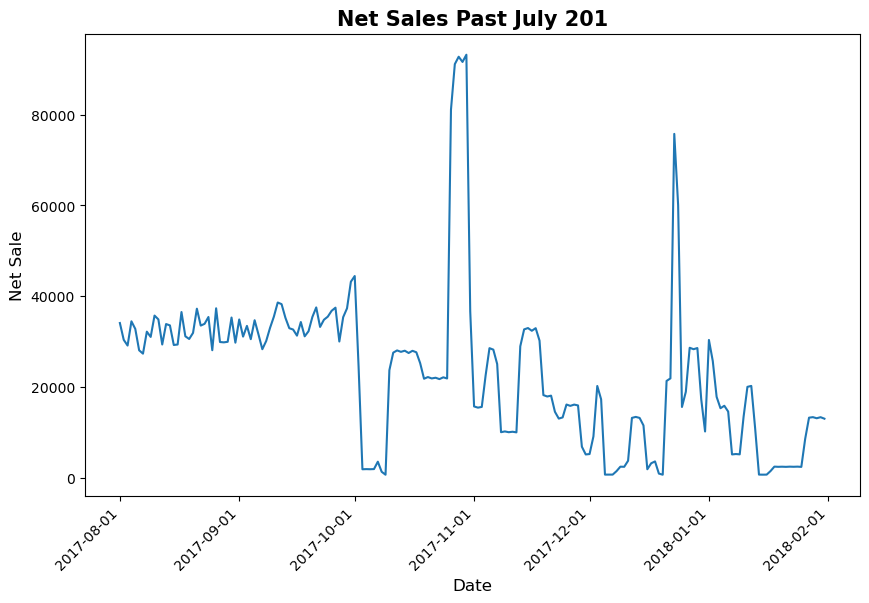

In [103]:
plt.figure(figsize=(10, 6))

plot_data = sc_orders[(sc_orders['order_year_month_only'] > '17-07')].groupby('order_date_only')['net_sale'].sum().reset_index()
ax = sns.lineplot(data=plot_data, x='order_date_only', y='net_sale')

ax.set_title('Net Sales Past July 201', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net Sale', fontsize=12)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

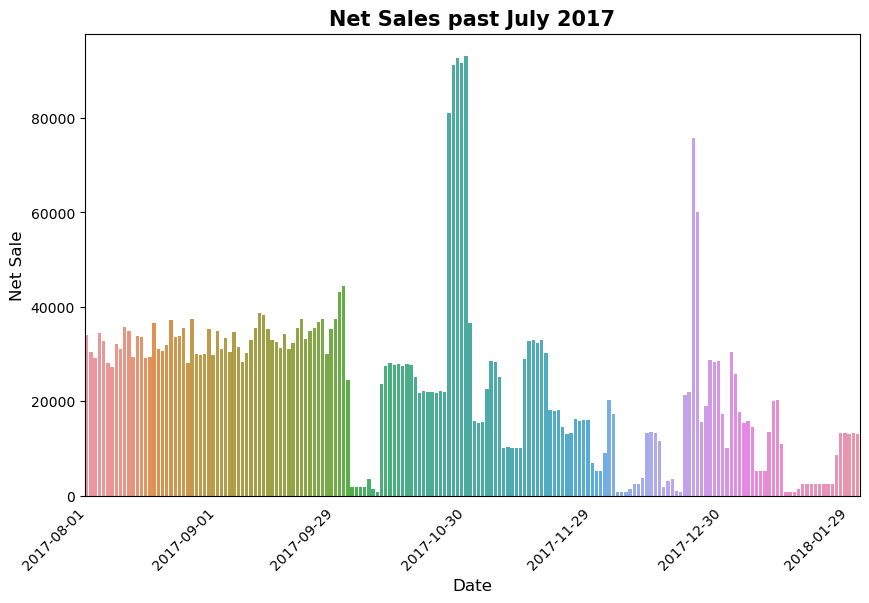

In [102]:
plt.figure(figsize=(10, 6))

plot_data = sc_orders[(sc_orders['order_year_month_only'] > '17-07')].groupby('order_date_only')['net_sale'].sum().reset_index()
ax = sns.barplot(data=plot_data, x='order_date_only', y='net_sale')

ax.set_title('Net Sales past July 2017', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net Sale', fontsize=12)
ax.xaxis.set_major_locator(MonthLocator())
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([item.get_text() for item in ax.get_xticklabels()], rotation=45, horizontalalignment='right')
ax.tick_params(bottom=False)

plt.show()

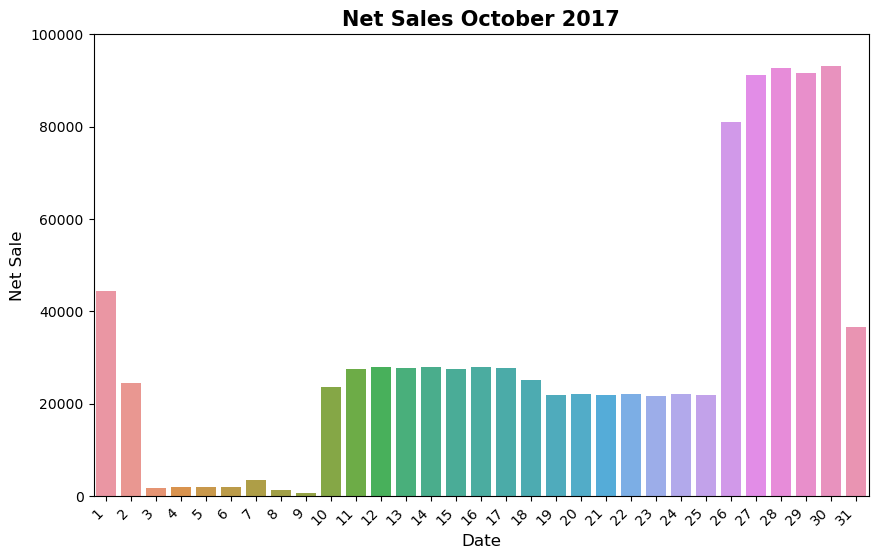

In [101]:
plt.figure(figsize=(10, 6))

plot_data = sc_orders[(sc_orders['order_year_month_only'] == '17-10')].groupby('order_day_only')['net_sale'].sum().reset_index()
ax = sns.barplot(data=plot_data, x='order_day_only', y='net_sale')

ax.set_title('Net Sales October 2017', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net Sale', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylim(0, 100000)

plt.show()

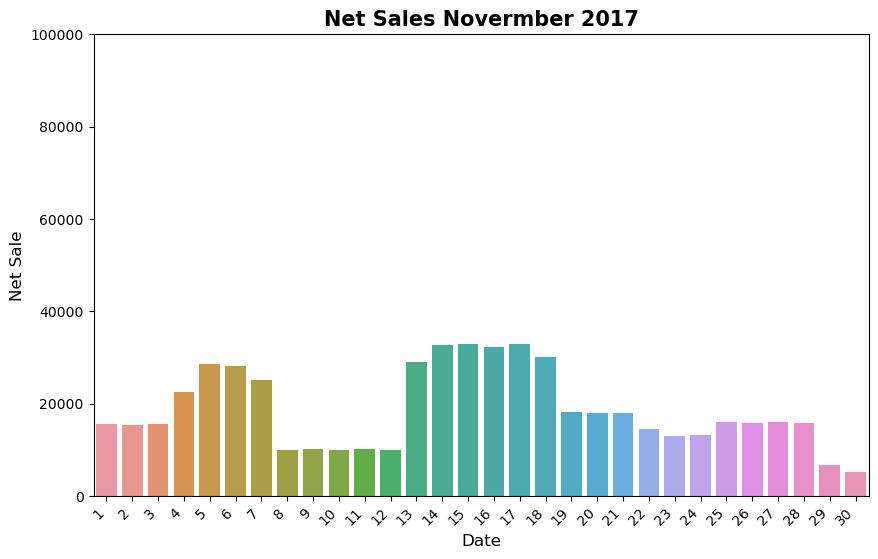

In [106]:
plt.figure(figsize=(10, 6))

plot_data = sc_orders[(sc_orders['order_year_month_only'] == '17-11')].groupby('order_day_only')['net_sale'].sum().reset_index()
ax = sns.barplot(data=plot_data, x='order_day_only', y='net_sale')

ax.set_title('Net Sales Novermber 2017', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net Sale', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylim(0, 100000)

plt.show()

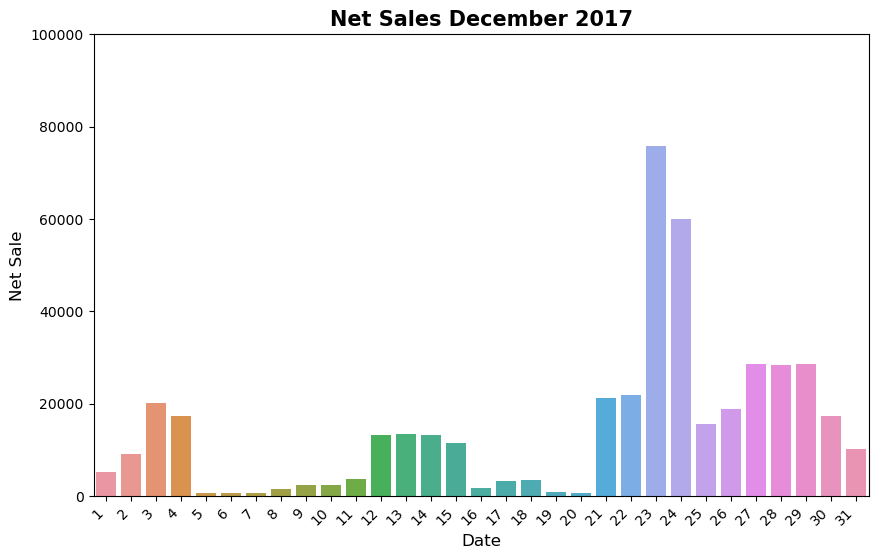

In [107]:
plt.figure(figsize=(10, 6))

plot_data = sc_orders[(sc_orders['order_year_month_only'] == '17-12')].groupby('order_day_only')['net_sale'].sum().reset_index()
ax = sns.barplot(data=plot_data, x='order_day_only', y='net_sale')

ax.set_title('Net Sales December 2017', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net Sale', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylim(0, 100000)

plt.show()

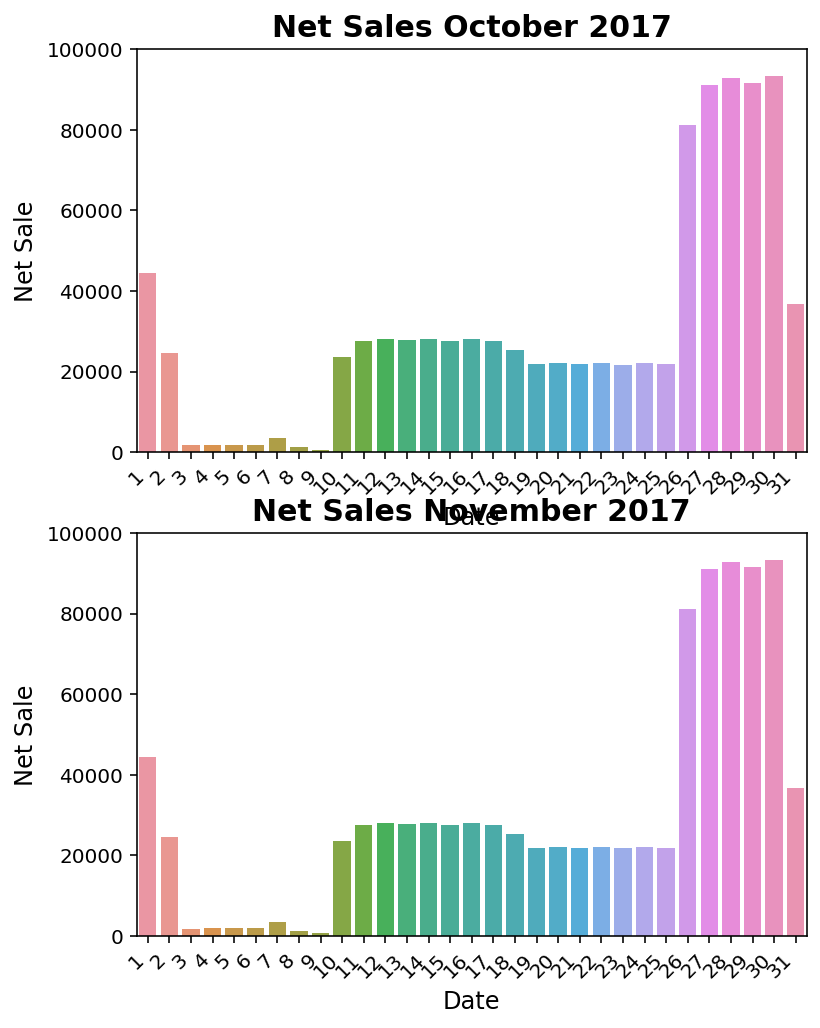

In [160]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(, 8), dpi=144)

ax1_plot_data = sc_orders[(sc_orders['order_year_month_only'] == '17-10')].groupby('order_day_only')['net_sale'].sum().reset_index()
sns.barplot(data=ax1_plot_data, x='order_day_only', y='net_sale', ax=ax1)

ax1.set_title('Net Sales October 2017', fontsize=15, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Net Sale', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_ylim(0, 100000)

ax2_plot_data = sc_orders[(sc_orders['order_year_month_only'] == '17-11')].groupby('order_day_only')['net_sale'].sum().reset_index()
sns.barplot(data=ax1_plot_data, x='order_day_only', y='net_sale', ax=ax2)

ax2.set_title('Net Sales November 2017', fontsize=15, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Net Sale', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2.set_ylim(0, 100000)

plt.show()


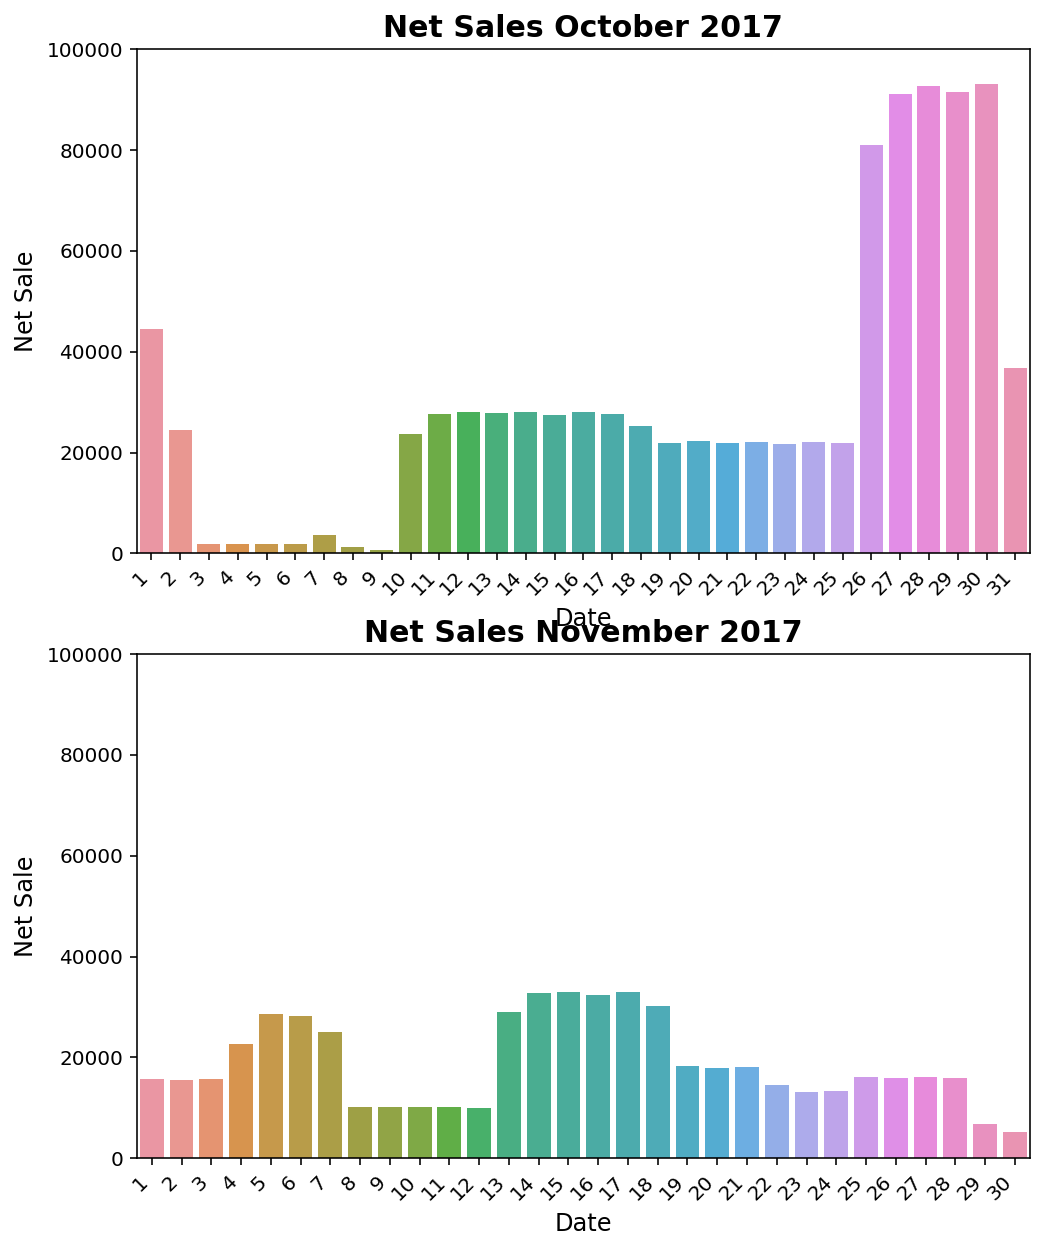

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the figure and subplots with increased height for each subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 20), dpi=144, gridspec_kw={'height_ratios': [3, 3]})

# Plot for October 2017
plot_data_ax1 = sc_orders[(sc_orders['order_year_month_only'] == '17-10')].groupby('order_day_only')['net_sale'].sum().reset_index()
sns.barplot(data=plot_data_ax1, x='order_day_only', y='net_sale', ax=ax1)

ax1.set_title('Net Sales October 2017', fontsize=15, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Net Sale', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_ylim(0, 100000)

# Plot for November 2017
plot_data_ax2 = sc_orders[(sc_orders['order_year_month_only'] == '17-11')].groupby('order_day_only')['net_sale'].sum().reset_index()
sns.barplot(data=plot_data_ax2, x='order_day_only', y='net_sale', ax=ax2)

ax2.set_title('Net Sales November 2017', fontsize=15, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Net Sale', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2.set_ylim(0, 100000)

plt.show()


In [ ]:
ax = sns.lineplot(data=sc_orders[(sc_orders['order_year_month_only'] == '17-09')].groupby('order_date_only')['net_sale'].sum().reset_index(), x='order_date_only', y='net_sale')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [ ]:
ax = sns.lineplot(data=sc_orders.groupby('order_year_month_only')['net_sale'].sum().reset_index(), x='order_year_month_only', y='net_sale')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [ ]:
sc_orders.groupby('order_year_month_only')['net_sale'].sum().reset_index()

In [ ]:
sc_orders.groupby('discount_pct')['net_sale'].mean()

In [ ]:
sc_orders.groupby('discount_pct')['net_sale'].sum()

In [ ]:
sc_orders.groupby('discount_pct')['price'].mean()

In [ ]:
sc_orders[['discount_pct', 'net_sale']].corr()

In [ ]:
sns.scatterplot(data=sc_orders, x='discount_pct', y='net_sale')

In [ ]:
sc_orders[['discount_pct', 'quantity']].corr()

In [ ]:
sns.scatterplot(data=sc_orders, x='discount_pct', y='quantity')

In [ ]:
sc_orders[['discount_pct', 'price']].corr()

In [ ]:
sns.scatterplot(data=sc_orders, x='discount_pct', y='price')

In [ ]:
sns.lineplot(data=sc_orders, x='order_date', y=sc_orders['price'].sum())

In [ ]:
sc_orders['order_date'].describe()

In [ ]:
sc_orders.groupby('price')['order_date'].mean().reset_index()

In [ ]:
sns.lineplot(data=sc_orders.groupby('price')['order_date'].mean().reset_index(), x='order_date', y='price')

In [ ]:
sc_orders.columns.tolist()

In [ ]:
table = sc_orders[['transaction_id', 'order_id', 'order_date', 'price', 'net_sale']]
table

In [ ]:
table['order_date'].dt.date.reset_index()

In [ ]:
table

In [ ]:
table['yyyy_mm_dd'] = table['order_date'].dt.date.astype(str)
table

In [ ]:
table.loc['date_only'] = table['order_date'].dt.date.astype(str)